In [488]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

import seaborn as sns
import pandas_profiling

from collections import Counter
%matplotlib inline

In [489]:
flight_input=pd.read_csv(r'flight_data.csv')

In [490]:
report = pandas_profiling.ProfileReport(flight_input)
#covert profile report as html file
report.to_file("flight_data.html")


In [491]:
flight_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336776 entries, 0 to 336775
Data columns (total 19 columns):
year              336776 non-null int64
month             336776 non-null int64
day               336776 non-null int64
dep_time          328521 non-null float64
sched_dep_time    336776 non-null int64
dep_delay         328521 non-null float64
arr_time          328063 non-null float64
sched_arr_time    336776 non-null int64
arr_delay         327346 non-null float64
carrier           336776 non-null object
flight            336776 non-null int64
tailnum           334264 non-null object
origin            336776 non-null object
dest              336776 non-null object
air_time          327346 non-null float64
distance          336776 non-null int64
hour              336776 non-null int64
minute            336776 non-null int64
time_hour         336776 non-null object
dtypes: float64(5), int64(9), object(5)
memory usage: 48.8+ MB


# Dropping tailnum as its not unique and is not making anny sense...

In [492]:
flight_input.drop(['tailnum'],axis=1,inplace=True)

### Data wrangling 

# Making missing value of dep_delay populated as median of delay...

In [493]:
flight_input['dep_delay'].fillna(flight_input['dep_delay'].median(),inplace=True)

# Updating  missing value of Actual dep_time with help of Schedule Depar hour and minute + dep_delay

In [494]:
def cal_dep1_time(scheddeptime_delay):
    scheddeptime,delay = scheddeptime_delay
    hour,minute = divmod(scheddeptime,100)
    totalSecs = (hour * 60 + minute + delay) * 60
    totalSecs, sec = divmod(totalSecs, 60)
    hr, min = divmod(totalSecs, 60)
    return float("%d%02d" % (hr, min))

flight_input['dep_time'] = flight_input[['sched_dep_time','dep_delay']].apply(cal_dep1_time, axis=1)

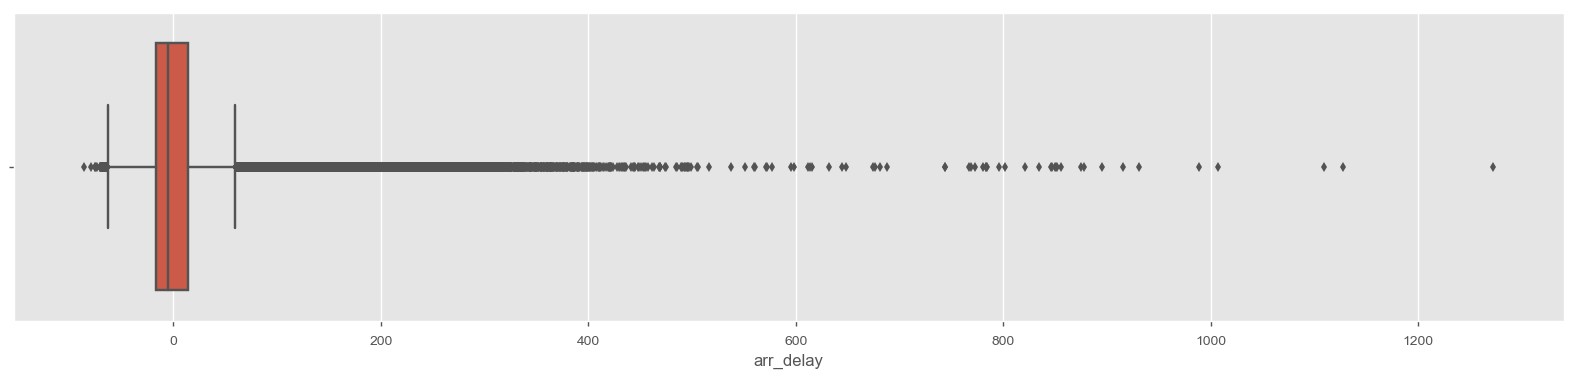

In [495]:
#To find the median of arr_delay using  box plot and see outliers too
from matplotlib import style
style.use('ggplot')
plt.figure(figsize=(20,4))
sns.boxplot(x='arr_delay',data=flight_input)


In [496]:
flight_input.describe()['arr_delay']

count    327346.000000
mean          6.895377
std          44.633292
min         -86.000000
25%         -17.000000
50%          -5.000000
75%          14.000000
max        1272.000000
Name: arr_delay, dtype: float64

# Updating  missing value of arr_delay with help of diff between Actaul arrival time and schedule arrival time.

In [497]:
def cal_delay(time_schtime):

    time,schtime = time_schtime
    actime,acminute = divmod(time,100)
    sctime,scminute = divmod(schtime,100)
    totalSecs = (actime * 60 + acminute) * 60 - (sctime * 60 + scminute) * 60
    return totalSecs/60
    #else:
        
    
flight_input['arr_delay'] = flight_input[flight_input['arr_time'].notnull()][['arr_time','sched_arr_time']].apply(cal_delay, axis=1)

# Updating rest of  missing value of arr_delay with median of arr_delay.

In [498]:
flight_input['arr_delay'].fillna(flight_input['arr_delay'].median(),inplace=True)

# Updating  missing value of arr_time with help of Schedule Arrival hour and minute + arr_delay

In [499]:
flight_input.iloc[754,:]

year                        2013
month                          1
day                            1
dep_time                    2016
sched_dep_time              1930
dep_delay                     46
arr_time                     NaN
sched_arr_time              2220
arr_delay                     -6
carrier                       EV
flight                      4204
origin                       EWR
dest                         OKC
air_time                     NaN
distance                    1325
hour                          19
minute                        30
time_hour         1/1/2013 19:00
Name: 754, dtype: object

In [500]:
flight_input['arr_time'] = flight_input[['sched_arr_time','arr_delay']].apply(cal_dep1_time, axis=1)

In [501]:
flight_input.iloc[754,:]

year                        2013
month                          1
day                            1
dep_time                    2016
sched_dep_time              1930
dep_delay                     46
arr_time                    2214
sched_arr_time              2220
arr_delay                     -6
carrier                       EV
flight                      4204
origin                       EWR
dest                         OKC
air_time                     NaN
distance                    1325
hour                          19
minute                        30
time_hour         1/1/2013 19:00
Name: 754, dtype: object

In [502]:
flight_input['air_time'].describe()

count    327346.000000
mean        150.686460
std          93.688305
min          20.000000
25%          82.000000
50%         129.000000
75%         192.000000
max         695.000000
Name: air_time, dtype: float64

# Updating  missing value of air_time with help median with groupby as per flight and carrier or same as based on Origin and dest 

In [503]:
by_flight_carrier=flight_input.groupby(['flight','carrier'])

by_flight_carrier['air_time'].median()

flight  carrier
1       AA         326.0
        B6         151.0
        DL         191.5
        UA         142.0
        WN         111.5
2       B6          56.0
        WN         131.0
3       AA         326.0
        B6         199.0
        UA         184.5
        WN         127.0
4       B6          57.0
        DL         155.0
5       AS         324.0
        B6         147.0
6       B6          57.0
        DL         274.5
7       AS         326.0
        WN         238.0
8       B6          54.0
9       B6         137.0
10      B6          57.0
        UA         208.5
11      AS         334.0
        B6         150.5
        VX         348.0
12      B6          47.0
        UA         291.0
15      AS         320.0
        B6         315.0
                   ...  
6047    EV          64.0
6049    EV          46.0
6054    EV          44.0
6055    EV          51.0
6062    EV          24.5
6065    EV          95.0
6067    EV          92.0
6068    EV          75.5
6069    E

# Updating  missing value of air_time with help median with groupby as per flight and carrier

In [504]:
def impute_median(series):
    return series.fillna(series.median())
flight_input['air_time']=by_flight_carrier['air_time'].transform(impute_median)


In [505]:
 flight_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336776 entries, 0 to 336775
Data columns (total 18 columns):
year              336776 non-null int64
month             336776 non-null int64
day               336776 non-null int64
dep_time          336776 non-null float64
sched_dep_time    336776 non-null int64
dep_delay         336776 non-null float64
arr_time          336776 non-null float64
sched_arr_time    336776 non-null int64
arr_delay         336776 non-null float64
carrier           336776 non-null object
flight            336776 non-null int64
origin            336776 non-null object
dest              336776 non-null object
air_time          336757 non-null float64
distance          336776 non-null int64
hour              336776 non-null int64
minute            336776 non-null int64
time_hour         336776 non-null object
dtypes: float64(5), int64(9), object(4)
memory usage: 46.2+ MB


# To drop rows of airtime missing values even after median updates as they are single records.

In [506]:
flight_input[flight_input['air_time'].isnull()].index.tolist()

[1650,
 42937,
 105229,
 110509,
 127940,
 144295,
 144351,
 144517,
 144518,
 144519,
 203583,
 250396,
 251340,
 251353,
 275945,
 282337,
 308714,
 310127,
 310786]

In [507]:
flight_input.drop(flight_input[flight_input['air_time'].isnull()].index.tolist(),inplace=True)

In [508]:
flight_input.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336757 entries, 0 to 336775
Data columns (total 18 columns):
year              336757 non-null int64
month             336757 non-null int64
day               336757 non-null int64
dep_time          336757 non-null float64
sched_dep_time    336757 non-null int64
dep_delay         336757 non-null float64
arr_time          336757 non-null float64
sched_arr_time    336757 non-null int64
arr_delay         336757 non-null float64
carrier           336757 non-null object
flight            336757 non-null int64
origin            336757 non-null object
dest              336757 non-null object
air_time          336757 non-null float64
distance          336757 non-null int64
hour              336757 non-null int64
minute            336757 non-null int64
time_hour         336757 non-null object
dtypes: float64(5), int64(9), object(4)
memory usage: 48.8+ MB


In [509]:
f = flight_input['carrier'].groupby(flight_input['carrier']).count()
f.sort_values(ascending = False)

carrier
UA    58664
B6    54635
EV    54168
DL    48110
AA    32729
MQ    26397
US    20535
9E    18454
WN    12269
VX     5162
FL     3260
AS      714
F9      685
YV      601
HA      342
OO       32
Name: carrier, dtype: int64

# Create a new column of arival and dep delay as 1 or 0 if delay is more than +ve 15 Mins as significant delay.

In [510]:
def convert_delay(delay):
    if(delay>=15):
        delay=1
    else:
        delay=0
    return delay

flight_input['dep_del15']=flight_input['dep_delay'].apply(convert_delay)
flight_input['arr_del15']=flight_input['arr_delay'].apply(convert_delay)


# Create a new column of arival and dep delay with actual delay if above 0.

In [511]:
def convert_diff(delay):
    if(delay<0):
        delay=0
    return delay

flight_input['dep_del_new']=flight_input['dep_delay'].apply(convert_diff)
flight_input['arr_del_new']=flight_input['dep_delay'].apply(convert_diff)

In [512]:
flight_input.head()

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,...,dest,air_time,distance,hour,minute,time_hour,dep_del15,arr_del15,dep_del_new,arr_del_new
0,2013,1,1,517.0,515,2.0,830.0,819,11.0,UA,...,IAH,227.0,1400,5,15,1/1/2013 5:00,0,0,2.0,2.0
1,2013,1,1,533.0,529,4.0,850.0,830,20.0,UA,...,IAH,227.0,1416,5,29,1/1/2013 5:00,0,1,4.0,4.0
2,2013,1,1,542.0,540,2.0,923.0,850,33.0,AA,...,MIA,160.0,1089,5,40,1/1/2013 5:00,0,1,2.0,2.0
3,2013,1,1,544.0,545,-1.0,1004.0,1022,-18.0,B6,...,BQN,183.0,1576,5,45,1/1/2013 5:00,0,0,0.0,0.0
4,2013,1,1,554.0,600,-6.0,812.0,837,-25.0,DL,...,ATL,116.0,762,6,0,1/1/2013 6:00,0,0,0.0,0.0


# Beginning with EDA.

In [513]:
#Calculating % wise as what total % of dep_delays from 3 airports in 2013 out of total number of flights 
pct_flight_del = flight_input.dep_del15.value_counts()/len(flight_input)
pct_flight_del

0    0.783485
1    0.216515
Name: dep_del15, dtype: float64

In [514]:
#Calculating % wise as what total % of dep_delays from 3 airports in 2013 out of total number of flights which is 
#almost 1/4th of its flight 
flight_input.arr_del15.value_counts()/len(flight_input)

0    0.776076
1    0.223924
Name: arr_del15, dtype: float64

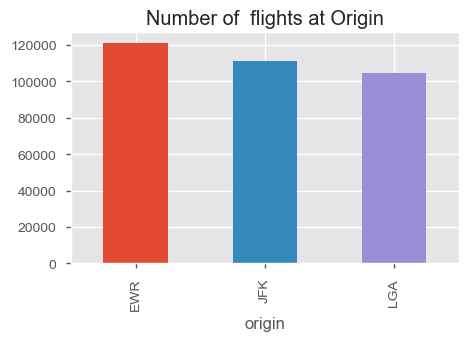

In [515]:
departure_Origin_counts = flight_input['dep_del15'].groupby(flight_input['origin']).count()
departure_Origin_counts
plt.figure(figsize=(5,3))
departure_Origin_counts.sort_values(ascending=False).plot(kind='bar', title='Number of  flights at Origin')

In [516]:
departure_delay_counts = flight_input['dep_del15'].groupby(flight_input['origin']).sum()
arrival_delay_counts = flight_input['arr_del15'].groupby(flight_input['dest']).sum()
#arrival_delay_counts.sort_values(ascending =False)
departure_delay_counts

origin
EWR    29775
JFK    23347
LGA    19791
Name: dep_del15, dtype: int64

# Analysis of Origin and Destination airport %delay and which is  worse aiport

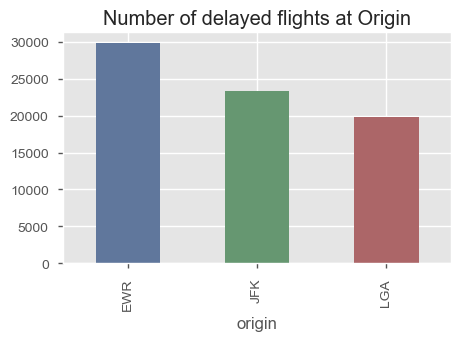

In [517]:
#Showing count of #flight delay at each orgin airport
sns.set_palette("deep",desat=.6)
colors= sns.color_palette("deep")
plt.figure(figsize=(5,3))
departure_delay_counts.sort_values(ascending=False).plot(kind='bar', title='Number of delayed flights at Origin')

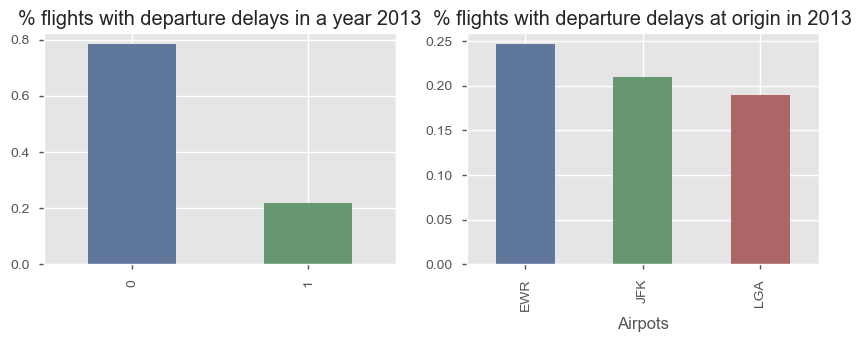

In [518]:
#Calculating % wise delay which will give clear pitcure as which is worse origin and dest airport where delay is maximum.


pct_departure_delay = departure_delay_counts / flight_input.origin.value_counts()
pct_arrival_delay = arrival_delay_counts / flight_input.dest.value_counts()
#We can see Newark airport is worst airport where departure delay is nearly 25% of total its total flights
#carr=['EV','B6','UA','DL','MQ','AA','9E','WN','US','VX','FL','F9','YV','AS','HA','OO']
plt.figure(figsize=(10,3))
plt.subplot(121)

pct_flight_del.sort_values(ascending=False).plot(kind='bar', title='% flights with departure delays in a year 2013')
plt.subplot(122)
pct_departure_delay.sort_values(ascending=False).plot(kind='bar', title='% flights with departure delays at origin in 2013')
plt.xlabel('Airpots')
plt.show()


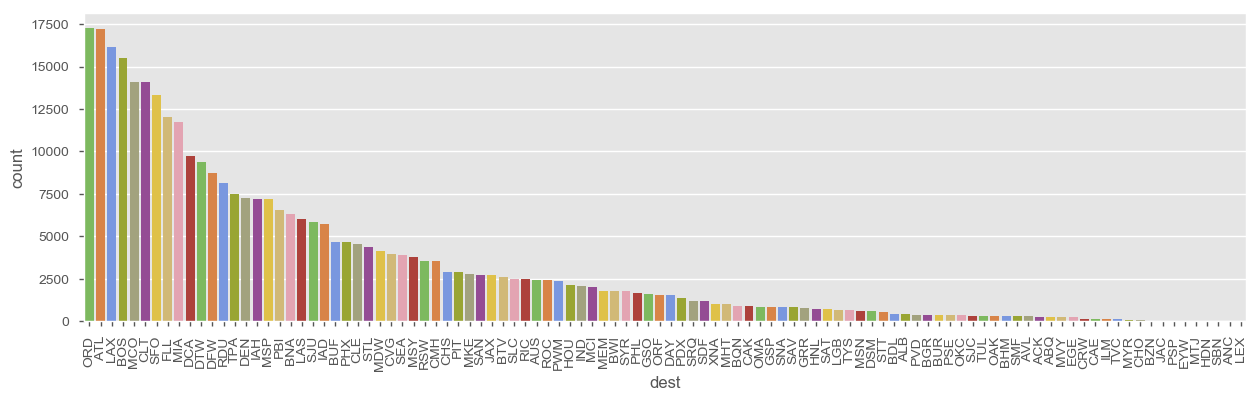

In [519]:
#Showing count of #flight at each dest airport
plt.figure(figsize=(15,4))
pkmn_type_colors = ['#78C850',  # WE
                    '#F08030',  # NA
                    '#6890F0',  # ANZ
                    '#A8B820',  # ME
                    '#A8A878',  # LA
                    '#A040A0',  # SA
                    '#F8D030',  # CEE
                    '#E0C068',  # EA
                    '#EE99AC',  # SSA
                    '#C03028',  # SA
                   ]
sns.countplot(x='dest', data=flight_input, palette=pkmn_type_colors,order = flight_input ['dest'].value_counts().index)
 # Rotate x-labels
plt.xticks(rotation=90);

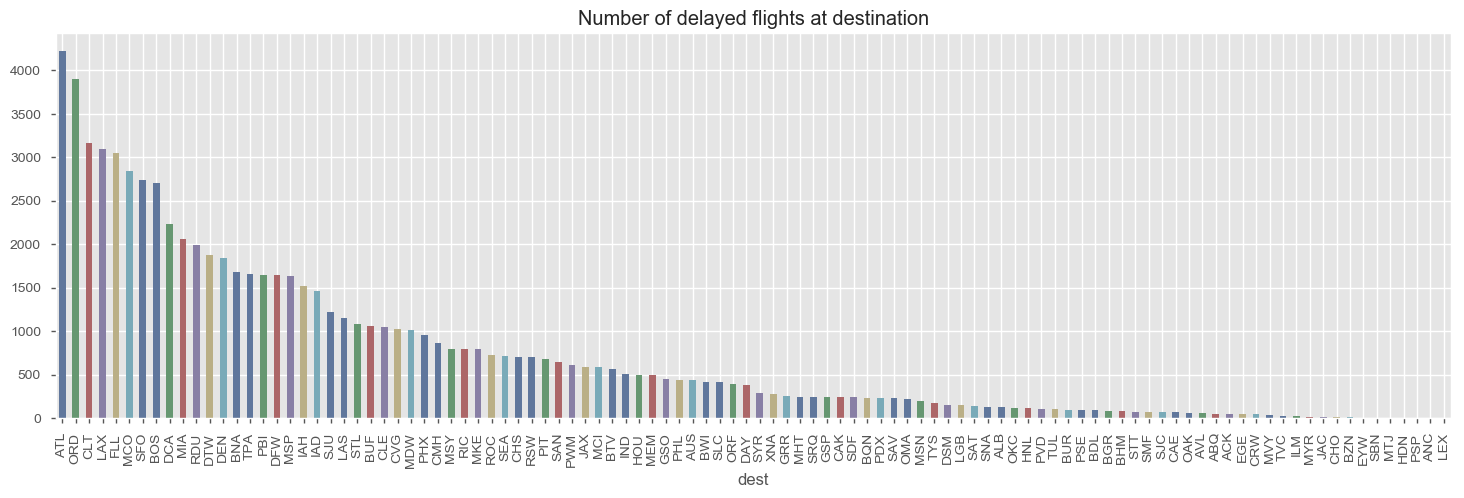

In [520]:
#Showing count of #flight delay at each dest airport
sns.set_palette("deep",desat=.6)
colors= sns.color_palette("deep")
plt.figure(figsize=(18,5))
arrival_delay_counts.sort_values(ascending=False).plot(kind='bar', title='Number of delayed flights at destination')

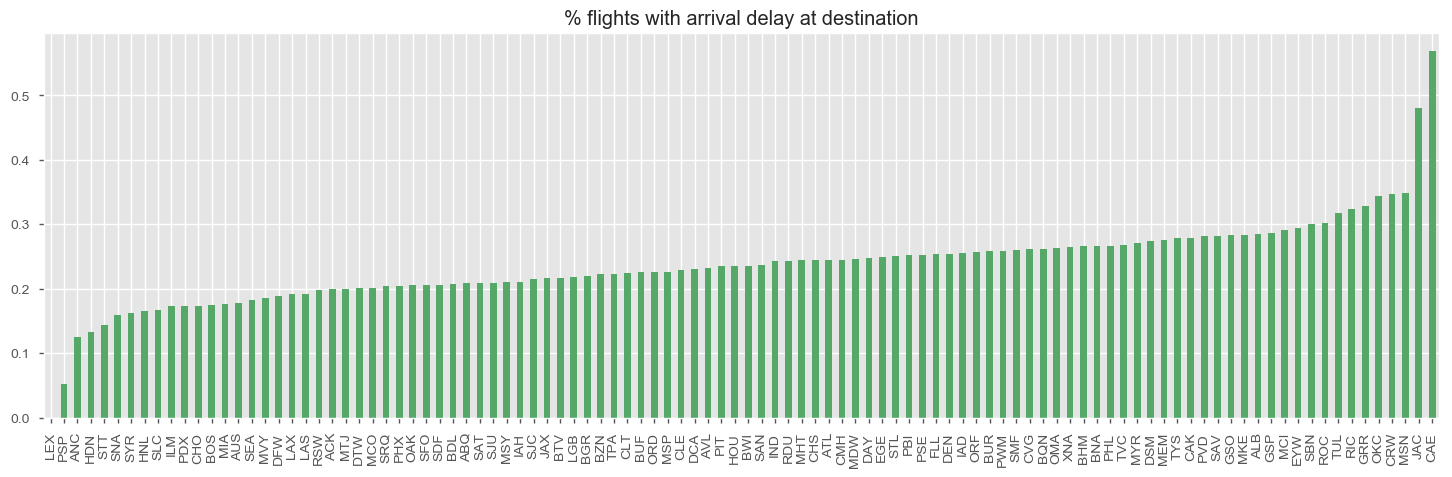

In [521]:
#Calculating % wise delay which will give clear pitcure as which is worse dest airport where delay is maximum
sns.set_palette("deep",desat=.6)
colors= sns.color_palette("deep")
plt.figure(figsize=(18,5))
pct_arrival_delay.sort_values(ascending=True).plot(kind='bar', color=colors[1], title='% flights with arrival delay at destination')

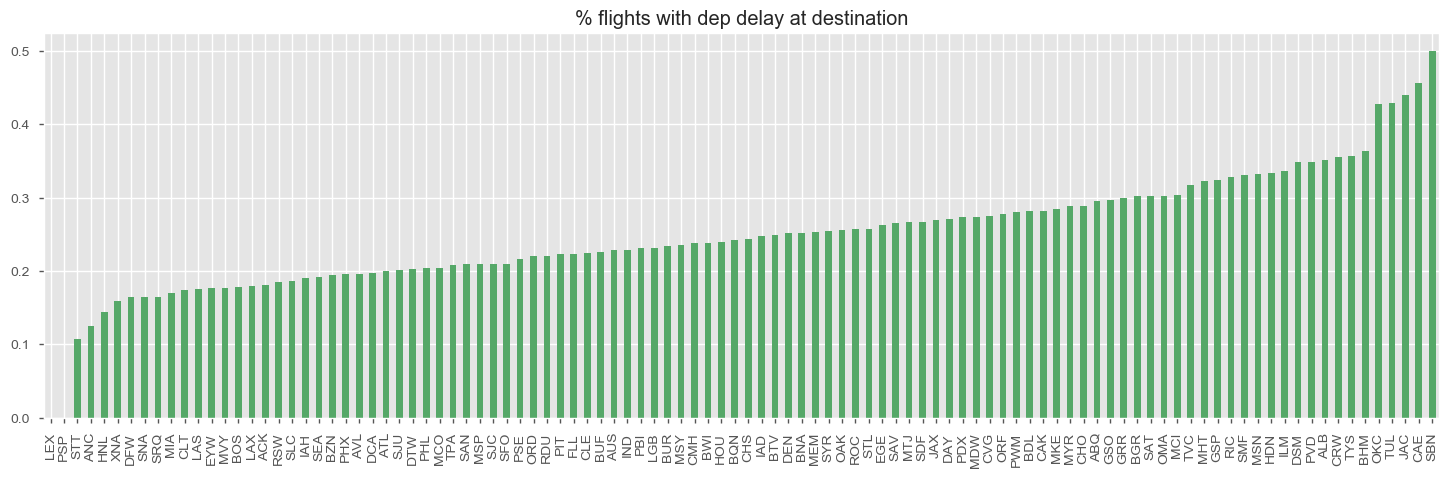

In [522]:
arrival_delay_counts1 = flight_input['dep_del15'].groupby(flight_input['dest']).sum()
pct_arrival_delay1 = arrival_delay_counts1 / flight_input.dest.value_counts()
plt.figure(figsize=(18,5))
pct_arrival_delay1.sort_values(ascending=True).plot(kind='bar', color=colors[1], title='% flights with dep delay at destination')

# Analysis of any Origin to detination airport specific case of delay

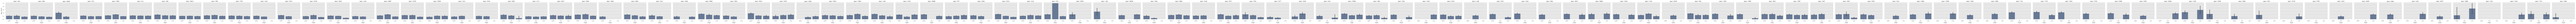

In [523]:
g = sns.FacetGrid(flight_input, col="dest") 
g.map(sns.barplot, 'origin','dep_del15', order = flight_input ['origin'].value_counts().index)

# Analysis of any specific carrier/airlines leading to origin &detination airport  delay

In [524]:
#Calculating carrier wise % from total flights
departure_carrier_counts = flight_input['flight'].groupby(flight_input['carrier']).count()
pct_departure_carrier= departure_carrier_counts / len(flight_input)*100
pct_departure_carrier.sort_values(ascending= False)


#arrival_delay_carrier_counts = flight_input['arr_del15'].groupby(flight_input['carrier']).sum()
#pct_departure_carrier_delay = departure_delay_carrier_counts / flight_input.carrier.value_counts()
#pct_arrival_carrier_delay = arrival_delay_carrier_counts / flight_input.carrier.value_counts()

#% of flight delay carrier wise out of total flights 
departure_delay_carrier_counts = flight_input['dep_del15'].groupby(flight_input['carrier']).sum()
pct_departure_carrier_delay_frmtotal = departure_delay_carrier_counts / len(flight_input)*100
#pct_departure_carrier_delay_frmtotal.sort_values(ascending= False)


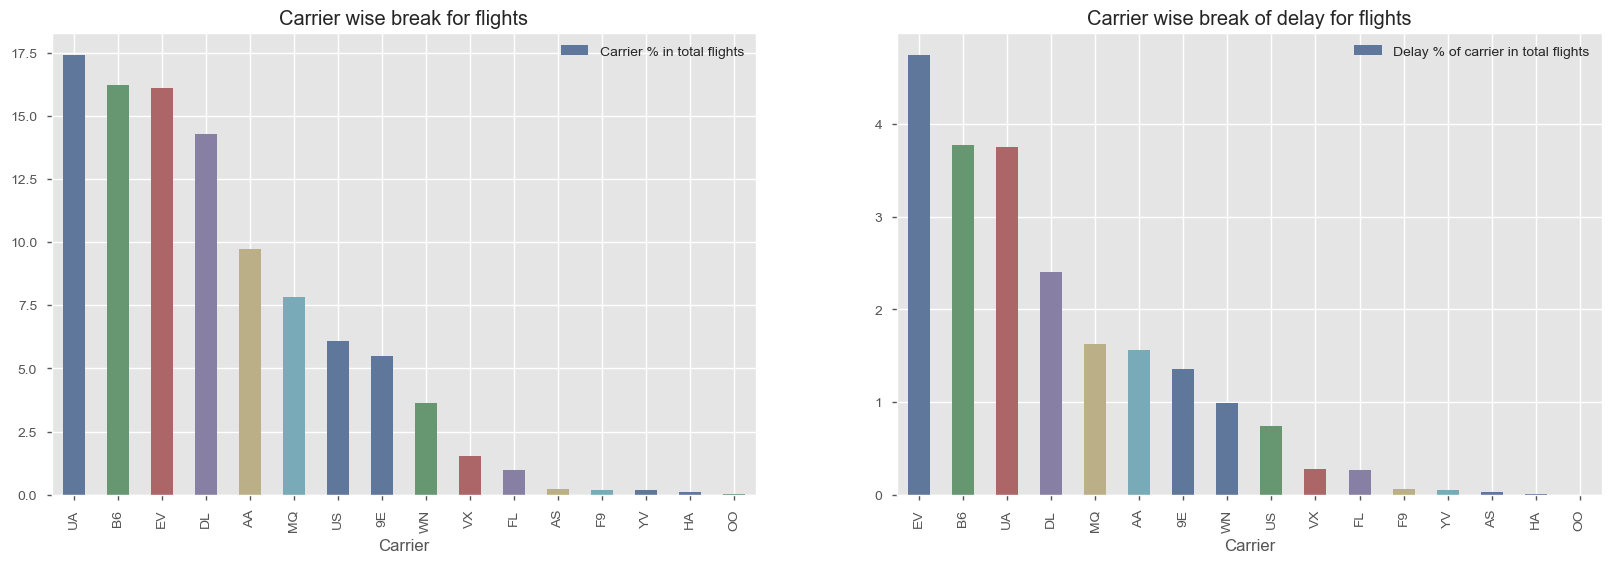

In [525]:
from matplotlib import pyplot as plt
#carr=['EV','B6','UA','DL','MQ','AA','9E','WN','US','VX','FL','F9','YV','AS','HA','OO']
plt.figure(figsize=(20,6))
plt.subplot(121)

pct_departure_carrier.sort_values(ascending=False).plot(kind='bar', title='Carrier wise break for flights',label='Carrier % in total flights')
plt.xlabel('Carrier')
plt.legend()
plt.subplot(122)
pct_departure_carrier_delay_frmtotal.sort_values(ascending=False).plot(kind='bar', title='Carrier wise break of delay for flights',label='Delay % of carrier in total flights')
plt.xlabel('Carrier')
plt.legend()
plt.show()

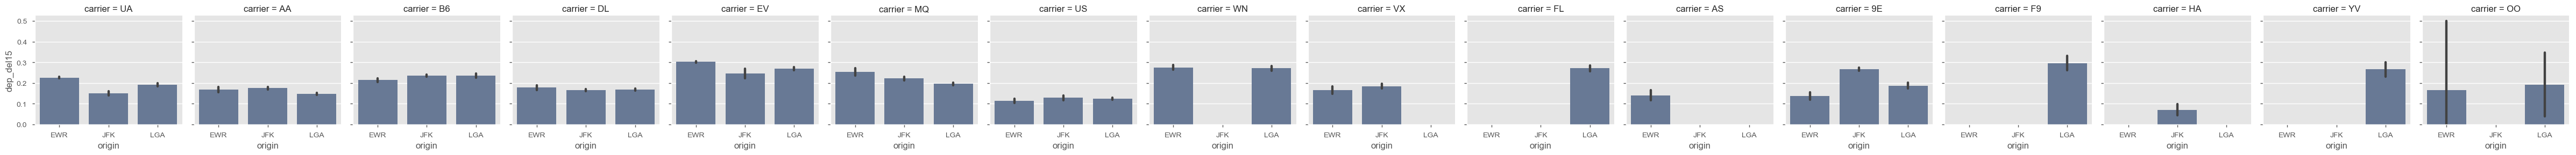

In [526]:
g = sns.FacetGrid(flight_input, col="carrier") 
g.map(sns.barplot, 'origin','dep_del15', order = flight_input ['origin'].value_counts().index)

# Speed analysis as if there is any impact on delay with aircraft speed.

In [527]:
#Calculating carrier wise speed as there is no Aircarft type to do actaul speed analysis    
flight_input['air_time_new'] = flight_input[['arr_time','dep_time']].apply(cal_delay, axis=1)
flight_input['speed']= flight_input['distance']/(flight_input['air_time']/60)
flight_input.head()

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,...,distance,hour,minute,time_hour,dep_del15,arr_del15,dep_del_new,arr_del_new,air_time_new,speed
0,2013,1,1,517.0,515,2.0,830.0,819,11.0,UA,...,1400,5,15,1/1/2013 5:00,0,0,2.0,2.0,193.0,370.044053
1,2013,1,1,533.0,529,4.0,850.0,830,20.0,UA,...,1416,5,29,1/1/2013 5:00,0,1,4.0,4.0,197.0,374.273128
2,2013,1,1,542.0,540,2.0,923.0,850,33.0,AA,...,1089,5,40,1/1/2013 5:00,0,1,2.0,2.0,221.0,408.375000
3,2013,1,1,544.0,545,-1.0,1004.0,1022,-18.0,B6,...,1576,5,45,1/1/2013 5:00,0,0,0.0,0.0,260.0,516.721311
4,2013,1,1,554.0,600,-6.0,812.0,837,-25.0,DL,...,762,6,0,1/1/2013 6:00,0,0,0.0,0.0,138.0,394.137931


<Figure size 3000x200 with 0 Axes>

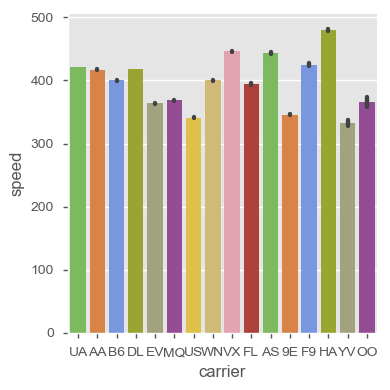

In [528]:
#sns.set_style('whitegrid')
plt.figure(figsize=(30,2))
pkmn_type_colors = ['#78C850',  # WE
                    '#F08030',  # NA
                    '#6890F0',  # ANZ
                    '#A8B820',  # ME
                    '#A8A878',  # LA
                    '#A040A0',  # SA
                    '#F8D030',  # CEE
                    '#E0C068',  # EA
                    '#EE99AC',  # SSA
                    '#C03028',  # SA
                    
                   ]

sns.factorplot(x='carrier', y='speed', 
               data=flight_input,palette=pkmn_type_colors,kind='bar', label = 'speed')



plt.show()

No handles with labels found to put in legend.


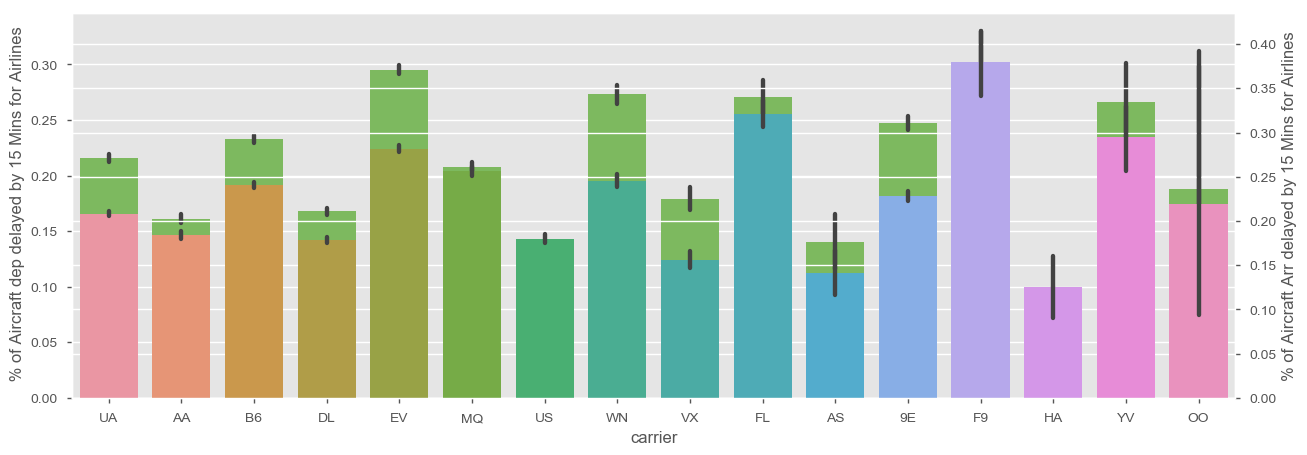

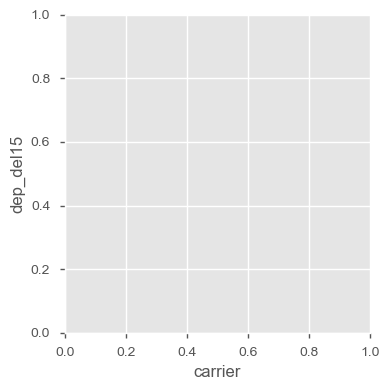

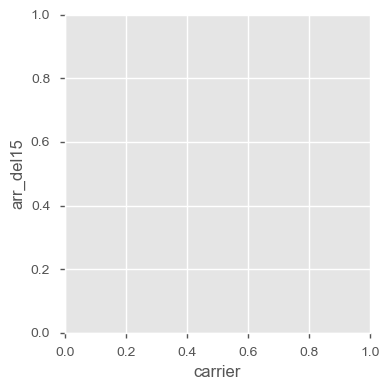

In [529]:
fig, ax1 = plt.subplots()

# Tell pointplot to plot on ax1 with the ax argument

sns.factorplot(x='carrier', y='dep_del15', 
               data=flight_input,color = '#78C850',kind='bar',ax=ax1,label='dep_del15')
ax1.set_ylabel(" % of Aircraft dep delayed by 15 Mins for Airlines")
ax2 = ax1.twinx()
#Tell the factorplot to plot on ax2 with the ax argument

sns.factorplot(x='carrier', y='arr_del15', 
               data=flight_input,kind='bar',ax=ax2,label='arr_del15')

ax2.set_ylabel("% of Aircraft Arr delayed by 15 Mins for Airlines")
#Close the FacetGrid figure which we don't need (g.fig)
#plt.close(g.fig)
fig.set_size_inches(15,5)
plt.legend()
plt.show()

# To do month wise analysis for delay

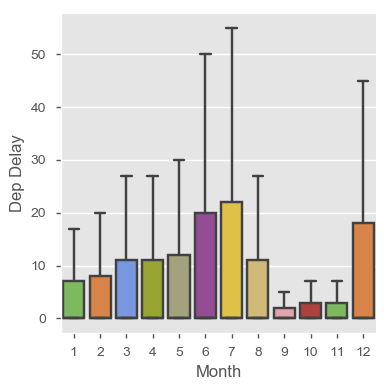

In [530]:
#PLotting blox plot shows that there is delay of 20-30 Mins in June July and Dec per flight as compared to less than 10 mins
#other months
#Further analysis of total flights increased or not during that month would show that delay was because of congestion in
#airport or  Bad weather or less staffing
#plt.figure(figsize=(5,4))
sns.factorplot(x='month',y='dep_del_new',
               data=flight_input,palette=pkmn_type_colors,kind='box', showfliers = False)
plt.xlabel("Month")
plt.ylabel("Dep Delay")

plt.show();

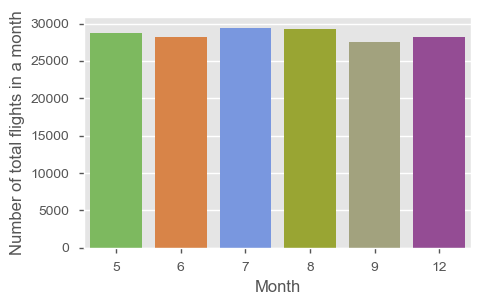

In [531]:
flight_month_data = flight_input.loc[flight_input['month'].isin([5,6,7,8,9,12])]
plt.figure(figsize=(5,3))
sns.countplot(x='month', data=flight_month_data, palette=pkmn_type_colors)
 # Rotate x-labels
plt.xlabel("Month")
plt.ylabel("Number of total flights in a month")

plt.show();

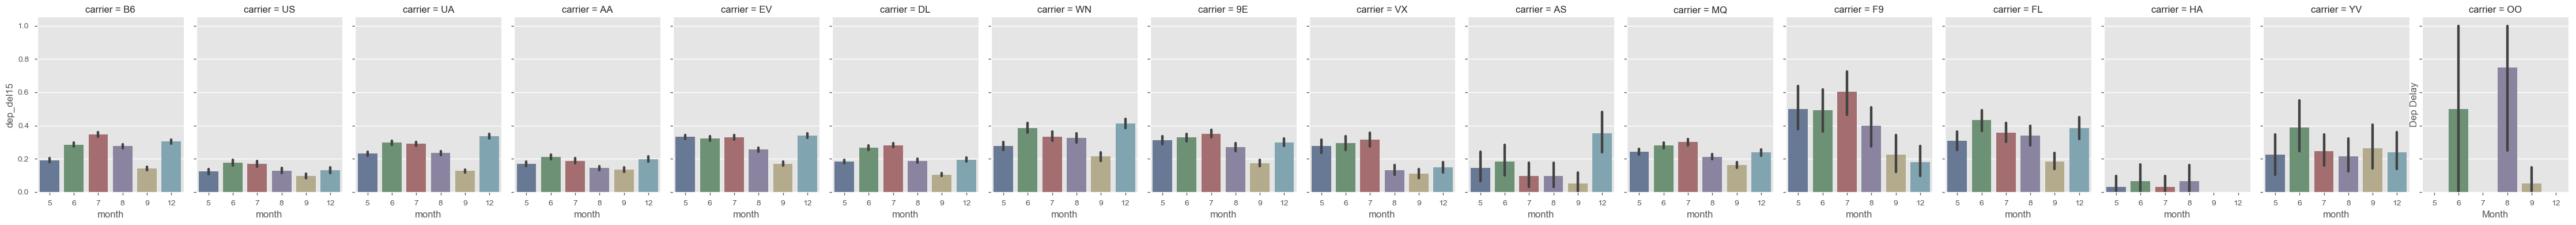

In [532]:
g= sns.factorplot(x='month', y='dep_del15',col= 'carrier',data=flight_month_data,kind='bar',aspect = .7,size=4)

plt.xlabel("Month")
plt.ylabel("Dep Delay")
plt.show()

In [533]:
h= flight_month_data.groupby(['month']).count()
h['flight']

month
5     28795
6     28242
7     29422
8     29325
9     27572
12    28133
Name: flight, dtype: int64

In [534]:
##Challenge-- How to display grouper with 2 or more columns
#To plot 2*2 subplot
#To plot multiple bar within a chart

In [535]:
origin_dummies = pd.get_dummies(flight_input['origin'],prefix='origin')
carrier_dummies = pd.get_dummies(flight_input['carrier'],prefix='carrier')

In [540]:
flight_input = pd.concat([flight_input,origin_dummies,carrier_dummies],axis=1)

In [537]:
#flight_input.drop(['origin_EWR','origin_LGA','origin_JFK'],axis=1,inplace= True)

In [541]:
flight_input.head()

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,...,carrier_MQ,carrier_OO,carrier_UA,carrier_US,carrier_VX,carrier_WN,carrier_YV,origin_EWR,origin_JFK,origin_LGA
0,2013,1,1,517.0,515,2.0,830.0,819,11.0,UA,...,0,0,1,0,0,0,0,1,0,0
1,2013,1,1,533.0,529,4.0,850.0,830,20.0,UA,...,0,0,1,0,0,0,0,0,0,1
2,2013,1,1,542.0,540,2.0,923.0,850,33.0,AA,...,0,0,0,0,0,0,0,0,1,0
3,2013,1,1,544.0,545,-1.0,1004.0,1022,-18.0,B6,...,0,0,0,0,0,0,0,0,1,0
4,2013,1,1,554.0,600,-6.0,812.0,837,-25.0,DL,...,0,0,0,0,0,0,0,0,0,1


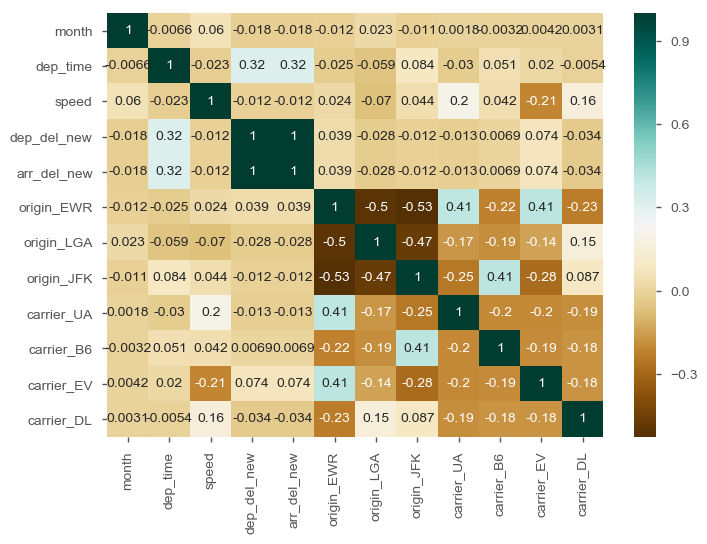

In [543]:
corr =flight_input[['month','dep_time','speed','dep_del_new','arr_del_new','origin_EWR','origin_LGA','origin_JFK',
                   'carrier_UA','carrier_B6','carrier_EV','carrier_DL']].corr()

#plt.figure(figsize=(10,4))
sns.heatmap(corr,cmap="BrBG",annot = True)
plt.show()

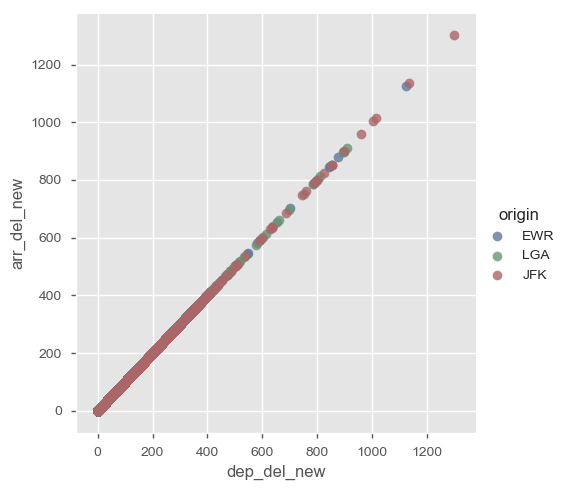

In [544]:
sns.lmplot(x='dep_del_new',y='arr_del_new',data=flight_input,fit_reg=False,hue='origin');

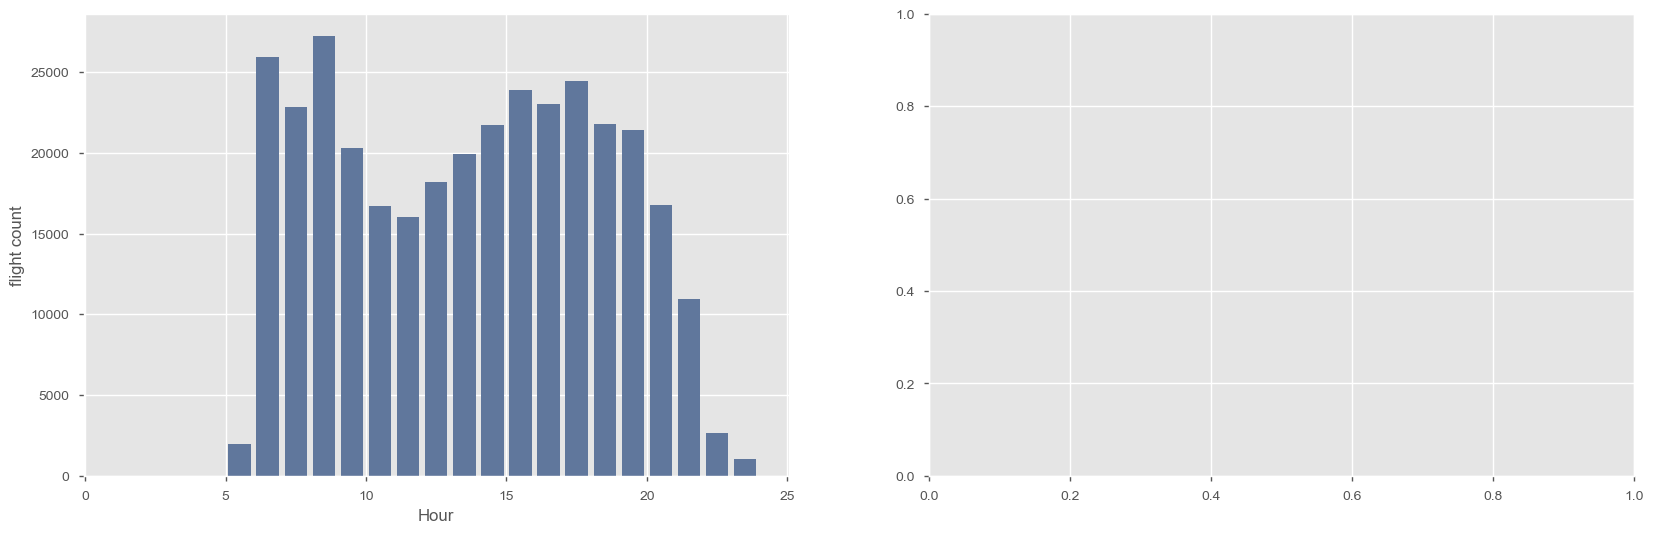

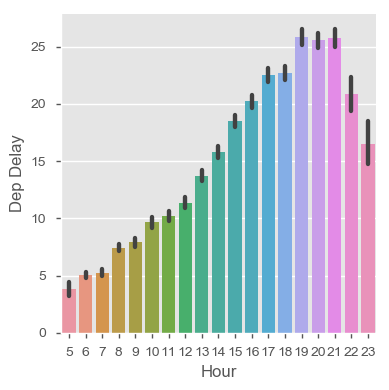

In [545]:
plt.figure(figsize=(20,6))
plt.subplot(121)

score = flight_input['hour']
bins = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
plt.hist(score, bins, histtype='bar', rwidth=0.8)
plt.xlabel('Hour')
plt.ylabel("flight count")
plt.subplot(122)
g= sns.factorplot(x='hour', y='dep_del_new',data=flight_input,kind='bar')
plt.xlabel("Hour")
plt.ylabel("Dep Delay")
plt.show()


<Figure size 500x300 with 0 Axes>

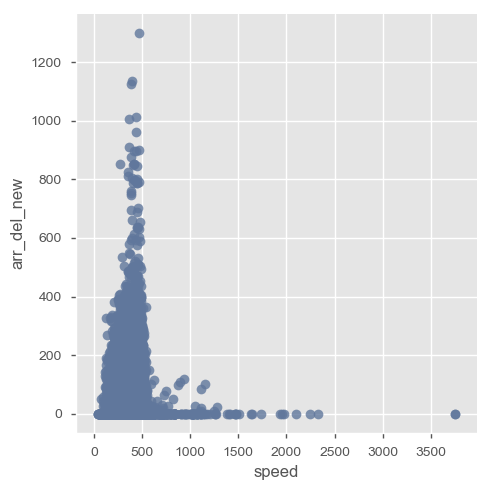

In [546]:
plt.figure(figsize=(5,3))
sns.lmplot(y='arr_del_new',x='speed',data=flight_input,fit_reg=False);
plt.show()